# **Course Rating Prediction using Neural Networks**


We will be training neural networks to predict course ratings while simultaneously extracting users' and items' latent features. 


## Objectives


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


## Prepare and setup lab environment


Install tensorflow 2.7 if not installed before in your Python environment


In [ ]:
!pip install tensorflow==2.7.0

and import required libraries:


In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

/tmp/ipykernel_55170/620955035.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-16 14:26:34.444442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# also set a random state
rs = 45

### Load and processing rating dataset


In [3]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`. 


Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [5]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

### Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [6]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [7]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [8]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [9]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [10]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [11]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [12]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

and training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [ ]:
y_train

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained


In [13]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

In [15]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

model.compile(optimizer = SGD(learning_rate = .003), loss = "MeanSquaredError", metrics=["RootMeanSquaredError"])

## - call model.compile() method to set up the loss and optimizer and metrics for the model training, you may use
##  - - tf.keras.losses.MeanSquaredError() as training loss
##  - - keras.optimizers.Adam() as optimizer
##  - - tf.keras.metrics.RootMeanSquaredError() as metric

## - call model.fit() to train the model
run_hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

## - optionally call model.save() to save the model

## - plot the train and validation loss
run_hist.history.keys()


Epoch 1/10


5833/5833 [==============================] - 29s 5ms/step - loss: 0.5400 - root_mean_squared_error: 0.7348 - val_loss: 0.3217 - val_root_mean_squared_error: 0.5671
Epoch 2/10
5833/5833 [==============================] - 29s 5ms/step - loss: 0.2215 - root_mean_squared_error: 0.4705 - val_loss: 0.1901 - val_root_mean_squared_error: 0.4360
Epoch 3/10
5833/5833 [==============================] - 29s 5ms/step - loss: 0.1364 - root_mean_squared_error: 0.3692 - val_loss: 0.1362 - val_root_mean_squared_error: 0.3690
Epoch 4/10
5833/5833 [==============================] - 29s 5ms/step - loss: 0.0986 - root_mean_squared_error: 0.3138 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3273
Epoch 5/10
5833/5833 [==============================] - 29s 5ms/step - loss: 0.0775 - root_mean_squared_error: 0.2783 - val_loss: 0.0895 - val_root_mean_squared_error: 0.2991
Epoch 6/10
5833/5833 [==============================] - 29s 5ms/step - loss: 0.0646 - root_mean_squared_error: 0.2540 - val_loss: 0.0778

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

Text(0.5, 1.0, 'RMSE over iterations')

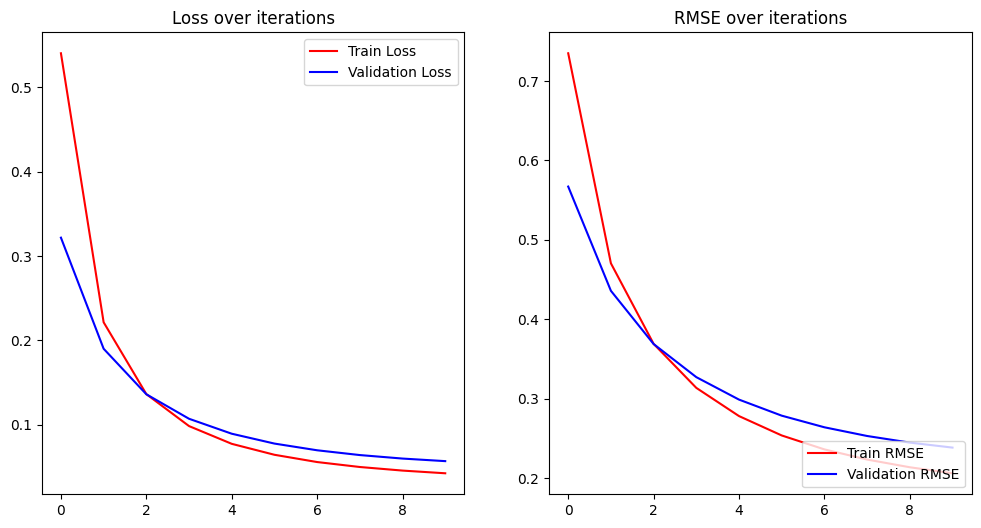

In [17]:
n = len(run_hist.history["loss"])
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(range(n), (run_hist.history["loss"]),'r', label = "Train Loss")
ax.plot(range(n), (run_hist.history["val_loss"]),'b', label = "Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1,2,2)
ax.plot(range(n), (run_hist.history["root_mean_squared_error"]),'r', label = "Train RMSE")
ax.plot(range(n), (run_hist.history["val_root_mean_squared_error"]),'b', label = "Validation RMSE")

ax.legend(loc='lower right')
ax.set_title('RMSE over iterations')

In [18]:
### - call model.evaluate() to evaluate the model
model.evaluate( x = x_val, y = y_val)


730/730 [==============================] - 2s 2ms/step - loss: 0.0572 - root_mean_squared_error: 0.2389


[0.057150065898895264, 0.23890420794487]

### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

If we print the trained model then we can see its layers and their parameters/weights.


In [19]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embe  multiple                  542416    
 dding)                                                          
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embe  multiple                  2016      
 dding)                                                          
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578459 (2.21 MB)
Trainable params: 578459 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [20]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [21]:
user_latent_features[0]

array([-0.00344711,  0.0081659 ,  0.00297383,  0.01462536, -0.01158507,
       -0.01032364,  0.03016496,  0.00233069,  0.01142321,  0.01910642,
        0.01190874,  0.0103254 ,  0.00121029, -0.00514729, -0.0119687 ,
        0.00350019], dtype=float32)

In [22]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [23]:
item_latent_features[0]

array([-0.11914238, -0.11810102,  0.09446773,  0.18481494, -0.21942274,
        0.01338983,  0.28330365, -0.0302321 , -0.05608254,  0.10130376,
       -0.12032366,  0.13360363, -0.08024013, -0.22942641, -0.06954806,
        0.21129738], dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### Summary


We have learned and practiced predicting course ratings using neural networks. With a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.
